In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('employee_data.csv')
df

,Salary,Job Satisfaction,Years of Experience,Employment Status
0,56.217808,2.666196,7,stay
1,96.550001,5.877109,3,stay
2,81.239576,8.856513,14,stay
3,71.906094,7.590024,10,stay
4,40.921305,8.259050,16,stay
...,...,...,...,...
995,36.410745,6.912596,19,leave
996,94.211950,9.609532,1,stay
997,39.577304,1.620622,7,leave
998,96.516615,1.513492,17,stay


In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()  
df1 = df.copy()
# Encode labels in column 'Employment Status' to 0 and 1. 
df1['Employment Status']= label_encoder.fit_transform(df1['Employment Status']) 
df1['Employment Status'].unique() 

array([1, 0])

In [4]:
print("Dataset with encoded 'Employment Status column")
df1

Dataset with encoded 'Employment Status column


,Salary,Job Satisfaction,Years of Experience,Employment Status
0,56.217808,2.666196,7,1
1,96.550001,5.877109,3,1
2,81.239576,8.856513,14,1
3,71.906094,7.590024,10,1
4,40.921305,8.259050,16,1
...,...,...,...,...
995,36.410745,6.912596,19,0
996,94.211950,9.609532,1,1
997,39.577304,1.620622,7,0
998,96.516615,1.513492,17,1


Employment Status
1    803
0    197
Name: count, dtype: int64


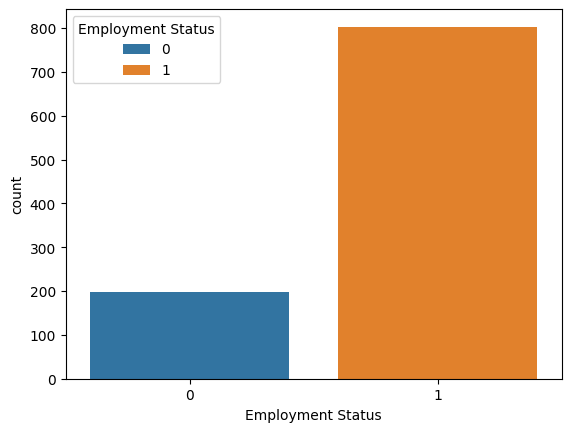

In [5]:
import seaborn as sns
sns.countplot(data=df1,x="Employment Status",hue="Employment Status")
print(df1['Employment Status'].value_counts())

In [6]:
from sklearn.utils import resample
df_majority=df1[(df1['Employment Status']==1)]
df_minority=df1[(df1['Employment Status']==0)]
df_minority_upsampled=resample(df_minority,n_samples=803,random_state=0)
df2=pd.concat([df_minority_upsampled,df_majority])

Employment Status
0    803
1    803
Name: count, dtype: int64


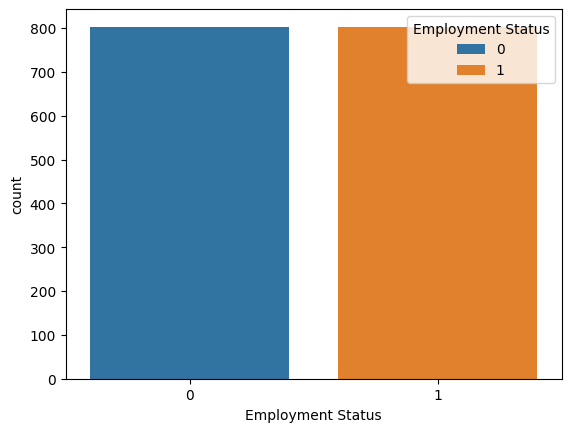

In [7]:
sns.countplot(data=df2,x="Employment Status",hue="Employment Status")
print(df2['Employment Status'].value_counts())

In [8]:
#check for missing values
print("Missing values:\n", df2.isnull().sum())

Missing values:
 Salary                 0
Job Satisfaction       0
Years of Experience    0
Employment Status      0
dtype: int64


In [9]:
#remove outliers 
z= np.abs((df2 - df2.mean()) / df2.std())
data_clean = df2[(z <3).all(axis=1)]
data_clean.shape

(1606, 4)

In [10]:
X1=data_clean.drop('Employment Status',axis=1)
y1=data_clean['Employment Status']

In [11]:
X = X1.values
y = y1.values

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234)

In [13]:
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels<=1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [14]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

In [15]:
clf = DecisionTree()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
acc = accuracy(y_test, predictions)
print('Accuracy:', round(acc*100,2) ,'%')

Accuracy: 100.0 %


In [16]:
# Prepare the input data for prediction
new_employee_data = np.array([[75000, 7, 5]])  # Salary, Job Satisfaction, Experience
predicted_status = clf.predict(new_employee_data)
print(f"The predicted employment status is {'leave' if predicted_status[0] == 0 else 'stay'}")

The predicted employment status is stay


In [17]:
new_employee_data = np.array([[15, 2, 5]])  # Salary, Job Satisfaction, Experience
predicted_status = clf.predict(new_employee_data)
print(f"The predicted employment status is {'leave' if predicted_status[0] == 0 else 'stay'}")

The predicted employment status is leave


In [18]:
new_employee_data = np.array([[75, 2, 5]])  # Salary, Job Satisfaction, Experience
predicted_status = clf.predict(new_employee_data)
print(f"The predicted employment status is {'leave' if predicted_status[0] == 0 else 'stay'}")

The predicted employment status is stay


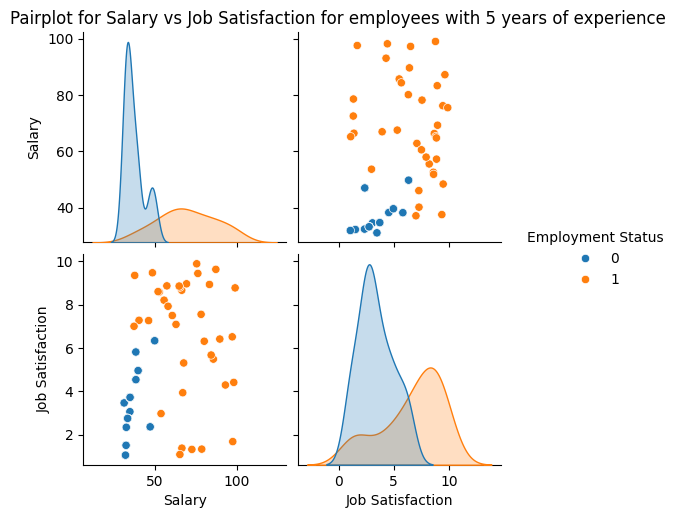

In [19]:
# Filter the dataframe for employees with 5 years of experience
filtered_df = data_clean[data_clean['Years of Experience'] == 5]
data_df2=filtered_df.drop(columns=['Years of Experience'])
sns.pairplot(data_df2, hue='Employment Status')
plt.suptitle('Pairplot for Salary vs Job Satisfaction for employees with 5 years of experience', y=1.02)
plt.show()